###Librerias

In [23]:
import pandas as pd
import geopandas as gpd
import folium
import shapely
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import requests
import requests, time
import unicodedata
import xgboost as xgb
import os, gc, time, unicodedata, requests
import xml.etree.ElementTree as ET
import statsmodels.formula.api as smf
import unicodedata, requests, pandas as pd, geopandas as gpd
import geopandas as gpd
import gradio as gr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from scipy.stats import ttest_ind, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display, Markdown
from folium.plugins import MarkerCluster, Search
from urllib3.util import Retry
from requests.adapters import HTTPAdapter
from folium.plugins import Search
from IPython.display import IFrame
from shapely.geometry import Point
from shapely.geometry import shape
from branca.element import Element
from shapely import voronoi_polygons
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from branca.colormap import LinearColormap
from matplotlib.ticker import LogLocator, FuncFormatter
from branca.element import Template, MacroElement
from IPython.display import HTML, display
from google.colab import files
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from missingno import matrix


2.C.a.  *Modelo Random Forest*

Está formado por múltiples árboles de decisión individuales. Cada uno de estos árboles es entrenado con una muestra ligeramente diferente de los datos de entrenamiento, generada mediante una técnica conocida como bootstrapping. Al realizar predicciones sobre nuevas observaciones, los resultados de todos los árboles se combinan en problemas de clasificación a través de votación mayoritaria, y en problemas de regresión mediante el promedio de las salidas.

Tiene como ventaja:

- La capaces de seleccionar predictores más relevantes de forma automática.
- Pueden aplicarse a problemas de regresión y clasificación.
- Los árboles pueden, manejar tanto predictores numéricos como categóricos sin tener que crear variables dummy o one-hot-encoding. En la práctica, esto depende de la implementación del algoritmo que tenga cada librería.
- Es muy útil en la exploración de datos, permite identificar de forma rápida y eficiente las variables (predictores) más importantes.
- Es adecuado para conjuntos de datos con un gran número de observaciones, demostrando una buena escalabilidad.

Tiene como desventaja:

- La combinación de múltiples árboles reduce la capacidad de interpretación en comparación con modelos basados en un solo árbol.
- Al tratar con predictores continuos, se puede perder parte de la información al categorizarlos durante la división de los nodos.
- La técnica de recursive binary splitting utilizada para crear las ramificaciones de los árboles puede favorecer a los predictores continuos o cualitativos con muchos niveles, ya que tienen una mayor probabilidad de contener un punto de corte óptimo por azar.

En el caso de la clasificación, el modelo recibe el nombre de Random Forest Classifier y se emplea para predecir variables categóricas. La predicción final se obtiene mediante un mecanismo de votación mayoritaria entre todos los árboles del bosque.

Por su parte, cuando se trabaja con variables continuas, se utiliza el Random Forest Regressor, orientado a resolver problemas de regresión. En este escenario, la predicción final corresponde al promedio de las salidas de todos los árboles, en lugar de una votación.

Se eligio para prueba el modelo Random Forest Regressor en el cual se ensayaron diferentes valores del hiperparámetro n_estimators, correspondiente a la cantidad de árboles en el bosque. En particular, se evaluaron configuraciones con 100, 500 y 800 árboles, con el objetivo de analizar el impacto de este parámetro en el desempeño del modelo.

### Dataset

In [9]:
# Bases
base_url_A = "https://raw.githubusercontent.com/FedericoGGM/diplodatos2025_M07/main/TP3/A_sets/"
base_url_B = "https://raw.githubusercontent.com/FedericoGGM/diplodatos2025_M07/main/TP3/B_sets/"

# === Conjunto A ===
y_A_train = pd.read_csv(base_url_A + "y_train_inicial.csv")
y_A_test  = pd.read_csv(base_url_A + "y_test_inicial.csv")

X_A_train_scaled = pd.read_csv(base_url_A + "x_A_train_norm.csv")
X_A_test_scaled  = pd.read_csv(base_url_A + "x_A_test_norm.csv")

X_A_train_std = pd.read_csv(base_url_A + "x_A_train_std.csv")
X_A_test_std  = pd.read_csv(base_url_A + "x_A_test_std.csv")

# === Conjunto B ===
y_B_train = pd.read_csv(base_url_B + "y_train_inicial.csv")
y_B_test  = pd.read_csv(base_url_B + "y_test_inicial.csv")

X_B_train_scaled = pd.read_csv(base_url_B + "x_B_train_norm.csv")
X_B_test_scaled  = pd.read_csv(base_url_B + "x_B_test_norm.csv")

X_B_train_std = pd.read_csv(base_url_B + "x_B_train_std.csv")
X_B_test_std  = pd.read_csv(base_url_B + "x_B_test_std.csv")

print("Conjuntos A y B cargados correctamente")


Conjuntos A y B cargados correctamente


In [15]:
# Diccionario de datasets
datasets_dict = {
    'A_scaled' : {'x_train':X_A_train_scaled, 'y_train':y_A_train, 'x_test':X_A_test_scaled, 'y_test':y_A_test},
    'A_std'    : {'x_train':X_A_train_std,    'y_train':y_A_train, 'x_test':X_A_test_std,    'y_test':y_A_test},
    'B_scaled' : {'x_train':X_B_train_scaled, 'y_train':y_B_train, 'x_test':X_B_test_scaled, 'y_test':y_B_test},
    'B_std'    : {'x_train':X_B_train_std,    'y_train':y_B_train, 'x_test':X_B_test_std,    'y_test':y_B_test},
}

## Modelo Random Forest Regressor

### Numero de arboles 100

In [25]:
# Iteracion sobre cada dataset
for nombre, data in datasets_dict.items():
    print(f"\n Resultados para {nombre}")

    # Extraer datos
    X_train, y_train = data['x_train'], data['y_train']
    X_test, y_test   = data['x_test'], data['y_test']

    # Entrenar modelo Random Forest Regressor
    modelo = RandomForestRegressor(
        n_estimators=100,   # número de árboles
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train.values.ravel())

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errores_abs = np.abs(y_test.values.ravel() - y_pred)
    min_error = errores_abs.min()
    max_error = errores_abs.max()

    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MIN error: {min_error:.3f}")
    print(f"MAX error: {max_error:.3f}")


 Resultados para A_scaled
MSE:  49.617
RMSE: 7.044
MIN error: 0.010
MAX error: 30.950

 Resultados para A_std
MSE:  49.461
RMSE: 7.033
MIN error: 0.020
MAX error: 30.240

 Resultados para B_scaled
MSE:  50.019
RMSE: 7.072
MIN error: 0.020
MAX error: 31.410

 Resultados para B_std
MSE:  49.898
RMSE: 7.064
MIN error: 0.040
MAX error: 31.130


### Numero de arboles 500

In [26]:
# Iteracion sobre cada dataset
for nombre, data in datasets_dict.items():
    print(f"\n Resultados para {nombre}")

    # Extraer datos
    X_train, y_train = data['x_train'], data['y_train']
    X_test, y_test   = data['x_test'], data['y_test']

    # Entrenar modelo Random Forest Regressor
    modelo = RandomForestRegressor(
        n_estimators=500,   # número de árboles
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train.values.ravel())

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errores_abs = np.abs(y_test.values.ravel() - y_pred)
    min_error = errores_abs.min()
    max_error = errores_abs.max()

    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MIN error: {min_error:.3f}")
    print(f"MAX error: {max_error:.3f}")


 Resultados para A_scaled
MSE:  48.794
RMSE: 6.985
MIN error: 0.112
MAX error: 30.184

 Resultados para A_std
MSE:  49.001
RMSE: 7.000
MIN error: 0.092
MAX error: 30.042

 Resultados para B_scaled
MSE:  48.652
RMSE: 6.975
MIN error: 0.090
MAX error: 30.060

 Resultados para B_std
MSE:  48.461
RMSE: 6.961
MIN error: 0.098
MAX error: 30.000


### Numero de arboles 800

In [36]:
# Iteracion sobre cada dataset
for nombre, data in datasets_dict.items():
    print(f"\n Resultados para {nombre}")

    # Extraer datos
    X_train, y_train = data['x_train'], data['y_train']
    X_test, y_test   = data['x_test'], data['y_test']

    # Entrenar modelo Random Forest Regressor
    modelo = RandomForestRegressor(
        n_estimators=800,   # número de árboles
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train.values.ravel())

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errores_abs = np.abs(y_test.values.ravel() - y_pred)
    min_error = errores_abs.min()
    max_error = errores_abs.max()

    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MIN error: {min_error:.3f}")
    print(f"MAX error: {max_error:.3f}")


 Resultados para A_scaled
MSE:  48.671
RMSE: 6.976
MIN error: 0.153
MAX error: 30.489

 Resultados para A_std
MSE:  48.863
RMSE: 6.990
MIN error: 0.121
MAX error: 30.351

 Resultados para B_scaled
MSE:  48.605
RMSE: 6.972
MIN error: 0.006
MAX error: 30.135

 Resultados para B_std
MSE:  48.411
RMSE: 6.958
MIN error: 0.016
MAX error: 30.068


### Tabla de comparacion de cantidad de arboles

In [48]:
resultados = []

# Dos configuraciones de n_estimators
for n_trees in [100, 500, 800]:
    for nombre, data in datasets_dict.items():
        # Extraer datos
        X_train, y_train = data['x_train'], data['y_train']
        X_test, y_test   = data['x_test'], data['y_test']

        # Entrenar modelo Random Forest Regressor
        modelo = RandomForestRegressor(
            n_estimators=n_trees,
            random_state=42,
            n_jobs=-1
        )
        modelo.fit(X_train, y_train.values.ravel())

        # Predicciones
        y_pred = modelo.predict(X_test)

        # Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        errores_abs = np.abs(y_test.values.ravel() - y_pred)
        min_error = errores_abs.min()
        max_error = errores_abs.max()

        # Guardar resultados en la lista
        resultados.append({
            "Dataset": nombre,
            "Árboles": n_trees,
            "MSE": round(mse, 3),
            "RMSE": round(rmse, 3),
            "MIN error": round(min_error, 3),
            "MAX error": round(max_error, 3)
        })
# Encontrar la fila con el menor RMSE
min_rmse_idx = df_resultados["RMSE"].idxmin()

# Función para aplicar estilo
def highlight_best(s):
    return ['color: darkgreen; font-weight: bold' if s.name == min_rmse_idx else '' for _ in s]

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla con estilo
print(" Resultados comparativos Random Forest")
display(df_resultados.style.apply(highlight_best, axis=1))

 Resultados comparativos Random Forest


,Dataset,Árboles,MSE,RMSE,MIN error,MAX error
0,A_scaled,100,49.617000,7.044000,0.010000,30.950000
1,A_std,100,49.461000,7.033000,0.020000,30.240000
2,B_scaled,100,50.019000,7.072000,0.020000,31.410000
3,B_std,100,49.898000,7.064000,0.040000,31.130000
4,A_scaled,500,48.794000,6.985000,0.112000,30.184000
5,A_std,500,49.001000,7.000000,0.092000,30.042000
6,B_scaled,500,48.652000,6.975000,0.090000,30.060000
7,B_std,500,48.461000,6.961000,0.098000,30.000000
8,A_scaled,800,48.671000,6.976000,0.153000,30.489000
9,A_std,800,48.863000,6.990000,0.121000,30.351000


La fila con el menor RMSE (mejor modelo) se marca en color verde oscuro.

### Grafico con las comparaciones

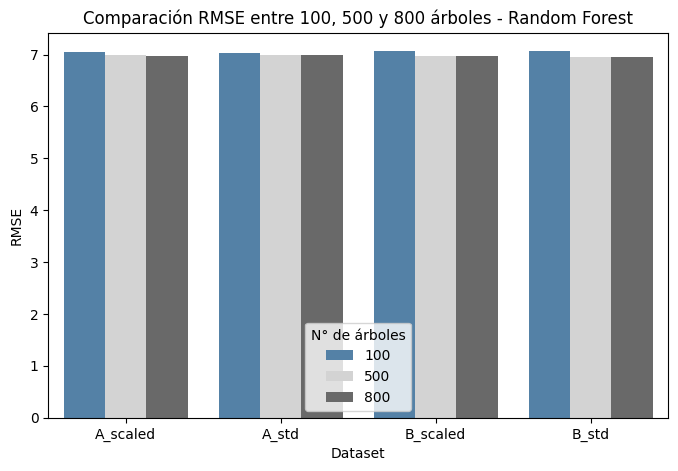

In [39]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_resultados,
    x="Dataset",
    y="RMSE",
    hue="Árboles",
    palette={100: "steelblue", 500: "lightgray", 800: "dimgray"}  # azul, gris claro y gris oscuro
)
plt.title("Comparación RMSE entre 100, 500 y 800 árboles - Random Forest")
plt.ylabel("RMSE")
plt.xlabel("Dataset")
plt.legend(title="N° de árboles")
plt.show()

### Conclusión de los resultados

La comparación de resultados con 100, 500 y 800 árboles muestra que el desempeño es muy estable en todos los conjuntos de datos, con valores de RMSE cercanos a 7 y MSE alrededor de 49. El incremento en la cantidad de árboles de 100 a 500 genera una leve mejora en la precisión del modelo, evidenciada en la reducción marginal del RMSE y MSE, aunque el cambio no es sustancial. El error mínimo aumenta ligeramente cuando se utilizan más árboles, lo que indica que las predicciones se vuelven menos exactas en algunos casos puntuales, pero a cambio se obtiene una mayor consistencia general. El error máximo se mantiene cercano a 30 en todos los escenarios, lo que revela la presencia de observaciones difíciles de predecir que no logran resolverse simplemente aumentando la cantidad de árboles. Al incorporar 800 árboles, se observa que el modelo no empeora, pero tampoco mejora de forma significativa respecto a los 500, lo cual confirma que a partir de cierto punto el Random Forest alcanza un nivel de saturación y más árboles solo incrementan el costo computacional sin generar beneficios reales. En conjunto, los resultados evidencian que Random Forest es un modelo robusto y poco sensible al escalado o estandarización de los datos, y que si bien más árboles ayudan a estabilizar las predicciones, la ganancia en rendimiento es marginal, lo cual sugiere que para mejorar significativamente el desempeño se necesitaría ajustar otros hiperparámetros o explorar modelos alternativos.

De acuerdo con los resultados obtenidos, el Random Forest Regressor entrenado con el dataset B estandarizado y con 800 árboles presentó el menor error de predicción (RMSE = 6.958 y MSE = 48.411), constituyéndose en la mejor configuración ensayada. Si bien el desempeño de este modelo es apenas superior al observado con 500 árboles, la consistencia alcanzada confirma que a partir de este punto ha llegado a un nivel de saturación en el que añadir más árboles no genera mejoras sustanciales en la precisión, aunque sí incrementa el costo computacional. Por este motivo, se selecciona este modelo como el más adecuado, ya que combina un rendimiento óptimo con una estabilidad robusta frente a las diferentes configuraciones evaluadas.

In [49]:
# Guardar resultados de 800 árboles
resultados_800 = {}

for nombre, data in datasets_dict.items():
    # Extraer datos
    X_train, y_train = data['x_train'], data['y_train']
    X_test, y_test   = data['x_test'], data['y_test']

    # Entrenar modelo Random Forest Regressor con 800 árboles
    modelo = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train.values.ravel())

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errores_abs = np.abs(y_test.values.ravel() - y_pred)
    min_error = errores_abs.min()
    max_error = errores_abs.max()

    # Guardar resultados
    resultados_800[nombre] = {
        "MSE": round(mse, 3),
        "RMSE": round(rmse, 3),
        "MIN error": round(min_error, 3),
        "MAX error": round(max_error, 3)
    }

# Mostrar resultados
print(" Resultados Random Forest con 800 árboles\n")
for nombre, res in resultados_800.items():
    print(f"{nombre}: {res}")


 Resultados Random Forest con 800 árboles

A_scaled: {'MSE': 48.671, 'RMSE': np.float64(6.976), 'MIN error': np.float64(0.153), 'MAX error': np.float64(30.489)}
A_std: {'MSE': 48.863, 'RMSE': np.float64(6.99), 'MIN error': np.float64(0.121), 'MAX error': np.float64(30.351)}
B_scaled: {'MSE': 48.605, 'RMSE': np.float64(6.972), 'MIN error': np.float64(0.006), 'MAX error': np.float64(30.135)}
B_std: {'MSE': 48.411, 'RMSE': np.float64(6.958), 'MIN error': np.float64(0.016), 'MAX error': np.float64(30.068)}
